# Training EfficientNetv2-S with Focal Loss on The Model

## Library Imports

In [1]:
from autogluon.multimodal import MultiModalPredictor
from ray import tune
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import torch
import os

torch.set_float32_matmul_precision("medium")

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-26 13:26:44,697	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-26 13:26:44,938	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
NUM_TRIALS = 100

## Data Imports

In [3]:
train_df = pd.read_csv("E:/Current_Workdir/palm-fruit-classification/data/clean/train_df.csv")
test_df = pd.read_csv("E:/Current_Workdir/palm-fruit-classification/data/clean/test_df.csv")

## Finetuning EfficientNet B2

Calculate class proportions for Focal Loss $\alpha$  
see [this](https://amaarora.github.io/posts/2020-06-29-FocalLoss.html) for details.

In [4]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df["label_text"]), y=train_df["label_text"])
class_weights_list = class_weights.tolist()
class_weights_list

[2.1965174129353233,
 1.1964769647696476,
 0.44327309236947793,
 5.660256410256411,
 0.5145687645687645,
 3.003401360544218]

Set Training Folder Name

In [5]:
now = datetime.datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
model_path = "../model/" + f"train_EfficientNetB2_100_trials_{timestamp_str}"

In [6]:
model_path

'../model/train_EfficientNetB2_100_trials_2024-12-26_13-26-45'

In [7]:
os.makedirs(model_path, exist_ok=True)

Defining Hyperparameters

In [8]:
hyperparameters = {
    "optimization.learning_rate": tune.loguniform(0.00001, 0.001),
    "optimization.max_epochs":tune.randint(5,20),
    "env.batch_size": tune.choice([8, 16, 32, 64, 128, 256]),
    #"env.batch_size": tune.qlograndint(8,128,2),
    "optimization.loss_function": "focal_loss",
    "optimization.focal_loss.alpha": class_weights_list,
    "optimization.focal_loss.gamma": tune.uniform(1, 3),
    "optimization.focal_loss.reduction": "sum",
    "model.timm_image.checkpoint_name": "tf_efficientnetv2_s.in1k",
    "optimization.optim_type": "adamw",
    "optimization.top_k_average_method": "best"
}

In [9]:
predictor = MultiModalPredictor(label="label_text", path=model_path, problem_type='multiclass', eval_metric="f1_macro")

In [10]:
hyperparameter_tune_kwargs = {
    "searcher": "bayes",
    "scheduler": "ASHA",
    "num_trials": NUM_TRIALS
}

In [11]:
predictor.fit(
        train_data=train_df,
        hyperparameters=hyperparameters,
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        # time_limit = 3600
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          32
Pytorch Version:    2.4.1
CUDA Version:       12.4
Memory Avail:       112.03 GB / 127.91 GB (87.6%)
Disk Space Avail:   1401.38 GB / 1863.00 GB (75.2%)


2024-12-26 13:27:16,971	ERROR tune_controller.py:1331 -- Trial task failed for trial 958b2b6e
Traceback (most recent call last):
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\_private\worker.py", line 2691, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Trial name,should_checkpoint,val_f1_macro
06c5c0c3,True,0.5114103555679321
07196310,True,0.5636899471282959
084f91e6,True,0.9065813422203064
0a38ea6a,True,0.24281874299049377
0bc9f6fb,True,0.990967333316803
11e480bd,True,0.41500574350357056
1225e980,True,0.4178485870361328
1240c0dc,True,0.16116967797279358
145c7c7c,True,0.4272937774658203
15d11770,True,0.4067420959472656


(raylet) The log monitor on node DESKTOP-JR4K5FK failed with the following error:
Traceback (most recent call last):
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\shutil.py", line 853, in move
    os.rename(src, real_dst)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\comp4\\AppData\\Local\\Temp\\ray\\session_2024-12-26_13-26-48_176368_34120\\logs\\worker-84eea17c06af8d5b1897eae9f223867b673b19a2c791a6a2397d9fc2-01000000-16760.err' -> 'C:\\Users\\comp4\\AppData\\Local\\Temp\\ray\\session_2024-12-26_13-26-48_176368_34120\\logs\\old\\worker-84eea17c06af8d5b1897eae9f223867b673b19a2c791a6a2397d9fc2-01000000-16760.err'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\_private\log_monitor.py", line 566, in <module>
    log_monitor.run()
  File "e:\Programs\miniforge3\env

2024-12-26 16:03:35,305	ERROR tune.py:1037 -- Trials did not complete: [958b2b6e]
Removing non-optimal trials and only keep the best one.
e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\autogluon\multimodal\utils\checkpoint.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't h

## Continue Training After Error

In [12]:
# predictor = MultiModalPredictor.load(model_path)

In [13]:
# predictor.fit(
#         train_data=train_df,
#         hyperparameters=hyperparameters,
#         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
#         # time_limit = 3600
# )

In [14]:
# predictor = MultiModalPredictor.load("e:/Current_Workdir/palm-fruit-classification/autogluon_ver/model/train_EfficientNetB2_2024-12-05_15-54-35")

## Evaluate on Test Dataset

In [15]:
scores = predictor.evaluate(test_df, metrics=["f1_macro", "f1_micro", "accuracy", "recall_macro", "precision_macro"])
scores

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:01<00:00,  8.05it/s]


{'f1_macro': 0.8982524698849397,
 'f1_micro': 0.8970976253298153,
 'accuracy': 0.8970976253298153,
 'recall_macro': 0.9066825217187535,
 'precision_macro': 0.8928573060077206}

In [16]:
preds = predictor.predict(test_df)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


In [17]:
true_labels = test_df['label_text']

# Classification Report

In [18]:
cr = classification_report(true_labels, preds)

In [19]:
print(cr)

              precision    recall  f1-score   support

 empty_bunch       0.95      0.91      0.93        23
    overripe       0.90      0.85      0.88        54
        ripe       0.89      0.92      0.90       154
      rotten       0.88      0.88      0.88         8
   underripe       0.91      0.88      0.89       130
      unripe       0.83      1.00      0.91        10

    accuracy                           0.90       379
   macro avg       0.89      0.91      0.90       379
weighted avg       0.90      0.90      0.90       379



In [20]:
cm = confusion_matrix(true_labels, preds)

In [21]:
cm

array([[ 21,   1,   0,   1,   0,   0],
       [  1,  46,   6,   0,   1,   0],
       [  0,   3, 141,   0,  10,   0],
       [  0,   0,   0,   7,   1,   0],
       [  0,   1,  12,   0, 115,   2],
       [  0,   0,   0,   0,   0,  10]], dtype=int64)

Accuracy per Class

In [22]:
cm.diagonal()/cm.sum(axis=1)

array([0.91304348, 0.85185185, 0.91558442, 0.875     , 0.88461538,
       1.        ])

Detailed Classification Report

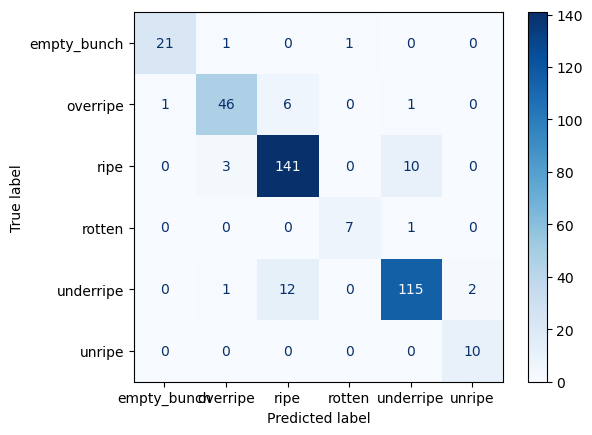

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Inference Example

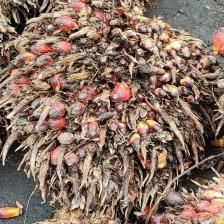

In [24]:
image_path = test_df.iloc[0]['image']
pil_img = Image.open(image_path)  # Use .open() instead of calling Image
display(pil_img)

In [25]:
predictions = predictor.predict({'image': [image_path]})
predictions

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


array(['overripe'], dtype=object)

In [26]:
proba = predictor.predict_proba({'image': [image_path]})
print(proba)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]
[[2.4709334e-03 9.9587256e-01 1.6268200e-03 1.2530571e-05 1.1863708e-05
  5.1727570e-06]]


In [27]:
feature = predictor.extract_embedding({'image': [image_path]})
print(feature[0].shape)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
(1280,)


## Save Raw TIMM Format

In [28]:
predictor.dump_model(model_path + "/timm")

Model timm_image weights saved to ../model/train_EfficientNetB2_100_trials_2024-12-26_13-26-45/timm\timm_image/pytorch_model.bin.
Timm config saved to ../model/train_EfficientNetB2_100_trials_2024-12-26_13-26-45/timm\timm_image/config.json.


'../model/train_EfficientNetB2_100_trials_2024-12-26_13-26-45/timm'